In [1]:
# libraires nécessaires
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, classification_report, average_precision_score

# 0. Lire des données

In [2]:
data_train = pd.read_table('train_set.csv',sep=',',header=0,index_col=0)
data_test = pd.read_table('val_set.csv',sep=',',header=0,index_col=0)
data_train.head(10)

,assur_caravane,nbmaisons,pouvoir_achat,nbpers_au_foyer,type_client,mt_auto,nb_auto,mt_incendie,nb_incendie,niv_etud_bas,...,marie,autre_relation,assur_sante_prive,assur_sante_public,mt_RC_entreprise,nb_RC_entreprise,mt_camion_livraison,nb_camion_livraison,nb_remorque,mt_remorque
cle,,,,,,,,,,,,,,,,,,,,,
5797,0,1,5,4,9,5,1,0,0,8,...,7,2,0,9,0,0,0,0,0,0
697,0,3,6,2,1,6,1,0,0,2,...,7,2,4,5,0,0,0,0,0,0
3853,0,1,5,1,8,0,0,0,0,0,...,6,3,5,4,0,0,0,0,0,0
4054,1,2,8,4,2,6,1,4,1,1,...,9,0,6,3,0,0,0,0,0,0
3765,0,1,3,2,8,6,1,0,0,4,...,7,2,3,6,0,0,0,0,0,0
5207,0,1,4,3,10,0,0,0,0,6,...,6,3,3,6,0,0,0,0,0,0
5015,1,1,8,4,1,6,1,4,1,1,...,8,1,7,2,0,0,0,0,0,0
4221,0,1,3,2,5,5,1,2,1,5,...,4,4,1,8,0,0,0,0,0,0
1857,0,1,7,3,3,0,0,0,0,4,...,5,5,5,5,0,0,0,0,0,0


# 1. Discrétisation des données

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree

def discretisation(df_entree):
    df = df_entree.copy()
    # Cas variables gardées : On ne rien faire
    
    # Cas Variables enlèvées : mt_RC_entreprise, nb_RC_entreprise, mt_camion_livraison,
    # nb_camion_livraison, nb_remorque, mt_remorque
    df.drop(columns =['mt_RC_entreprise', 'nb_RC_entreprise', 'mt_camion_livraison',
                       'nb_camion_livraison', 'nb_remorque', 'mt_remorque'], inplace=True, axis = 1)
    
    # Cas Variables modifiées faciles
    ## nbmaisons : groupe 1 et les autres dans group 2.
    #df.loc[df['nbmaisons'] > 1,'nbmaisons']='2et+'
    df['nbmaisons'][df['nbmaisons'] > 1] = '2et+'
    ## nbpers_au_foyer : groupe 1, groupe 2, groupe 3 et 5 dans group 4.
    df.loc[(df['nbpers_au_foyer'] == 5) | (df['nbpers_au_foyer'] == 4),'nbpers_au_foyer']='4+5'
    #df['nbpers_au_foyer'][(df['nbpers_au_foyer'] == 5) | (df['nbpers_au_foyer'] == 4)] = '4+5'
    ## mt_auto : On met 4 dans groupe 5 et 7,8 dans groupe 6.
    #df['mt_auto'][(df['mt_auto'] > 3) & (df['mt_auto'] < 6)] = '4+5'
    df.loc[(df['mt_auto'] > 3) & (df['mt_auto'] < 6),'mt_auto'] = '4+5'
    #df['mt_auto'][df['mt_auto'] == 6] = '6et+'
    df.loc[(df['mt_auto'] == 6) | (df['mt_auto'] == 7) | (df['mt_auto'] == 8),'mt_auto'] = '6et+'

    ## nb_auto : Groupe 0, group 1 et les autres dans groupe 2.
    df.loc[df['nb_auto'] > 1,'nb_auto'] = '2et+'
    ## nb_incendie : group 0 et les autres dans group 1.
    df.loc[df['nb_incendie'] > 0,'nb_incendie'] = '1et+'
    ## niv_etude_haut : groupe 0,1,2,3,4 et les autres dans groupe 5.
    df.loc[df['niv_etude_haut'] > 4,'niv_etude_haut'] = '5et+'
    ## revenu_moyen : 0, 1 dans groupe 2, groupe 3, groupe 4, groupe 5 et 7,8,9 dans groupe 6.
    df.loc[df['revenu_moyen'] < 3,'revenu_moyen'] = '2et-'
    df.loc[df['revenu_moyen'] == 6,'revenu_moyen'] = '6et+'
    df.loc[df['revenu_moyen'] == 7,'revenu_moyen'] = '6et+'
    df.loc[df['revenu_moyen'] == 8,'revenu_moyen'] = '6et+'
    df.loc[df['revenu_moyen'] == 9,'revenu_moyen'] = '6et+'
    ## nb_RC : Groupe 0 et 2 dans groupe 1.
    df.loc[df['nb_RC'] > 0,'nb_RC'] = '1et+'
    ## auto0 : Groupe 0, groupe 1, groupe 2, groupe 3, groupe 4 et 6,7,8,9 dans groupe 5.
    df.loc[df['auto0'] > 4,'auto0'] = '5et+'
    ## auto1 : 0,1,2 dans groupe 3, group 4, groupe 5, groupe 6, groupe 7, group 8, groupe 9
    df.loc[df['auto1'] < 4,'auto1'] = '3et-'
    ## revenu1 : groupe 0, group 1, groupe 2, groupe 3, groupe 4, group 5, et 7,8,9 dans groupe 6.
    df.loc[df['revenu1'] > 5,'revenu1'] = '6et+'
    ## revenu2 : groupe 0, group 1, groupe 2, groupe 3, groupe 4, group 5, groupe 6 et 8,9 dans groupe 7.
    df.loc[df['revenu2'] > 6,'revenu2'] = '7et+'
    ## revenu3 : Groupe 0, group 1, groupe 2, groupe 3, groupe 4, group 5 et 7,8,9 dans groupe 6.
    df.loc[df['revenu3'] > 5,'revenu3'] = '6et+'
    ## revenu4 : Groupe 0, group 1, groupe 2 et 4,5,6,7,8,9 dans groupe 3.
    df.loc[df['revenu4'] > 2,'revenu4'] = '3et+'
    ## marie : 0,1,2 dans groupe 3 et groupe 4, group 5, groupe 6, groupe 7, groupe 8, group 9.
    df.loc[df['marie'] < 4,'marie'] = '3et-'
    ## autre_relation : Groupe 0, group 1, groupe 2, groupe 3, groupe 4, groupe 5 et 7,8,9 dans groupe 6.
    df.loc[df['autre_relation'] > 5,'autre_relation'] = '6et+'

    # Cas variables modifiées difficiles :
    #### méthode supervisée : arbres de décision
    ## type_client : Groupe 4 dans 3. Groupe 6 dans 7.
    df.loc[(df['type_client'] == 3) | (df['type_client'] == 4),'type_client'] = '3+4'
    df.loc[df['type_client'] == 6 ,'type_client'] = '6+7'
    df.loc[df['type_client'] == 7 ,'type_client'] = '6+7'
    
    ## mt_incendie : On met 6,7,8 dans 5. 
    ## On ne sais pas décider avec le groupe 1.
    ## Avec l'aide d'arbre de décision en haut, on va mettre group 1 dans 0.
    df.loc[df['mt_incendie'] > 4,'mt_incendie'] = '5et+'
    df.loc[df['mt_incendie'] == 0,'mt_incendie'] = '1et-'   
    df.loc[df['mt_incendie'] == 1,'mt_incendie'] = '1et-'   
    
    ## mt_RC : On met groupe 3 dans groupes 2. 
    ## On ne sais pas décider avec le groupe 1.
    ## Avec l'aide d'arbre de décision en haut, on va mettre group 1 dans 0.
    df.loc[df['mt_RC'] > 3,'mt_RC'] = '2+3'
    df.loc[df['mt_RC'] ==0,'mt_RC'] = '0+1'
    df.loc[df['mt_RC'] ==1,'mt_RC'] = '0+1' 
    
    ## assur_sante_prive : On met groupe 8, 9 dans groupes 7.
    ## On ne sais pas décider avec le groupe 6. 
    ## Avec l'aide d'arbre de décision en haut, on va mettre groupe 6 dans 7.
    df.loc[df['assur_sante_prive'] > 5,'assur_sante_prive'] = '6et+' 
    
    ## assur_sante_public : On met groupe 0, 1 dans groupes 2. 
    ## On ne sais pas décider avec le groupe 3 (en 2 ou 4). 
    ## Avec l'aide d'arbre de décision en haut, on va mettre groupe 3 dans 4.
    df.loc[df['assur_sante_public'] < 3,'assur_sante_public'] = '2et-'
    df.loc[df['assur_sante_public'] ==3,'assur_sante_public'] = '3+4'
    df.loc[df['assur_sante_public'] ==4,'assur_sante_public'] = '3+4'
    
    return df

In [4]:
data_clean_train = discretisation(data_train)
y_train = data_clean_train['assur_caravane']
# Car il existe des donndées de type chaine de charactère. 
# Donc on va transforme en type numérique avec l'aide de la méthode dummies
# créer des dummies variables
data_clean_train=data_clean_train.drop(['assur_caravane','locataire', 'assur_sante_public'],axis=1)
data_clean_train=data_clean_train.astype(str)
data_train_dencode_3=pd.get_dummies(data_clean_train,drop_first=True)
data_train_dencode_3.head()

,nbmaisons_2et+,pouvoir_achat_2,pouvoir_achat_3,pouvoir_achat_4,pouvoir_achat_5,pouvoir_achat_6,pouvoir_achat_7,pouvoir_achat_8,nbpers_au_foyer_2,nbpers_au_foyer_3,...,autre_relation_3,autre_relation_4,autre_relation_5,autre_relation_6et+,assur_sante_prive_1,assur_sante_prive_2,assur_sante_prive_3,assur_sante_prive_4,assur_sante_prive_5,assur_sante_prive_6et+
cle,,,,,,,,,,,,,,,,,,,,,
5797,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3853,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4054,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3765,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
data_clean_test = discretisation(data_test)
y_test = data_clean_test['assur_caravane']
## idem pour données tests
# créer des dummies variables
data_clean_test=data_clean_test.drop(['assur_caravane','locataire', 'assur_sante_public'],axis=1)
data_clean_test=data_clean_test.astype(str)
data_test_dencode_3=pd.get_dummies(data_clean_test,drop_first=True)
data_test_dencode_3.head()

,nbmaisons_2et+,pouvoir_achat_2,pouvoir_achat_3,pouvoir_achat_4,pouvoir_achat_5,pouvoir_achat_6,pouvoir_achat_7,pouvoir_achat_8,nbpers_au_foyer_2,nbpers_au_foyer_3,...,autre_relation_3,autre_relation_4,autre_relation_5,autre_relation_6et+,assur_sante_prive_1,assur_sante_prive_2,assur_sante_prive_3,assur_sante_prive_4,assur_sante_prive_5,assur_sante_prive_6et+
cle,,,,,,,,,,,,,,,,,,,,,
3657,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4252,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3951,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
177,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5218,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0


#  3. Travailler sur des abres

## Arbre 1 (sans utiliser hyperparamètres)

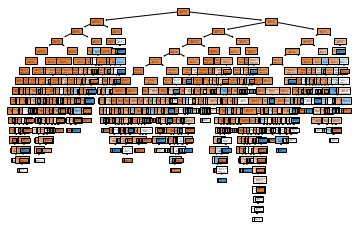

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz, plot_tree
from sklearn import tree
#Construction d'un arbre de décision
#arbre avec les paramètres par défaut
arbre1 = DecisionTreeClassifier()
arbre1.fit(data_train_dencode_3,y_train)
tree.plot_tree(arbre1, filled=True,feature_names=data_train_dencode_3.columns)
plt.show()

<b>Conclusion </b>
<br>Le graphe est illisible
<br>Trop de noeuds.

## Performance de Arbre 1 

In [7]:
# Fonction 
def mesure_perf(X,y,model):
    #matrice de confusion
    pred=model.predict(X)
    print("Matrice de confusion :")
    print(confusion_matrix(y,pred))
    
    #rapport de classification
    print("Rapport de classification :")
    print(classification_report(y,pred))
    
    #aire sous la courbe ROC
    print("aire sous la courbe ROC :",roc_auc_score(y,pred))
    
    #aire sous la courbe PRC
    print("aire sous la courbe PRC :",average_precision_score(y,pred))

In [8]:
mesure_perf(data_train_dencode_3,y_train, arbre1)

Matrice de confusion :
[[4378    3]
 [  65  211]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4381
           1       0.99      0.76      0.86       276

    accuracy                           0.99      4657
   macro avg       0.99      0.88      0.93      4657
weighted avg       0.99      0.99      0.98      4657

aire sous la courbe ROC : 0.8819039892288505
aire sous la courbe PRC : 0.767733048846669


In [9]:
mesure_perf(data_test_dencode_3,y_test, arbre1)

Matrice de confusion :
[[1036   57]
 [  63    9]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1093
           1       0.14      0.12      0.13        72

    accuracy                           0.90      1165
   macro avg       0.54      0.54      0.54      1165
weighted avg       0.89      0.90      0.89      1165

aire sous la courbe ROC : 0.5364249771271729
aire sous la courbe PRC : 0.07112270776433866


Sur la validation, la précision du modèle est très mauvaise en ce qui concerne la classe 1. 
La prédiction sur la validation révèle un grand sur-apprentissage : l'aire sous la courbe PRC a baissé de .77 à .07 et la précision a aussi beaucoup chuté.
    
    => rajouter hyperparpamètres 

## Arbre 2 (essayer le profond d'arbre)

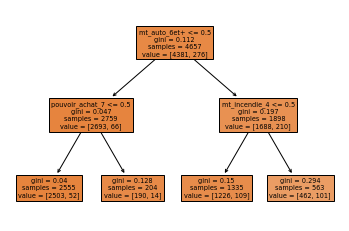

In [10]:
#Construction d'un arbre de décision
#arbre avec les paramètres max_depth = 3
arbre2 = DecisionTreeClassifier(max_depth =2)
arbre2.fit(data_train_dencode_3,y_train)
tree.plot_tree(arbre2, filled=True,feature_names=data_train_dencode_3.columns)
plt.show()

Trop de orange

## Performance Arbre 2

In [11]:
mesure_perf(data_train_dencode_3,y_train, arbre2)

Matrice de confusion :
[[4381    0]
 [ 276    0]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4381
           1       0.00      0.00      0.00       276

    accuracy                           0.94      4657
   macro avg       0.47      0.50      0.48      4657
weighted avg       0.88      0.94      0.91      4657

aire sous la courbe ROC : 0.5
aire sous la courbe PRC : 0.05926562164483573


/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
mesure_perf(data_test_dencode_3,y_test, arbre2)

Matrice de confusion :
[[1093    0]
 [  72    0]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1093
           1       0.00      0.00      0.00        72

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.88      0.94      0.91      1165

aire sous la courbe ROC : 0.5
aire sous la courbe PRC : 0.061802575107296136


/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Arbre 3 (essayer nombre de feuille)

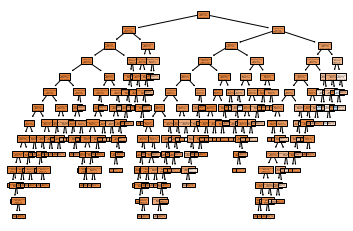

In [13]:
arbre3 = DecisionTreeClassifier(min_samples_leaf= 10)
arbre3.fit(data_train_dencode_3,y_train)
tree.plot_tree(arbre3, filled=True,feature_names=data_train_dencode_3.columns)
plt.show()

In [14]:
mesure_perf(data_train_dencode_3,y_train, arbre3)

Matrice de confusion :
[[4371   10]
 [ 261   15]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4381
           1       0.60      0.05      0.10       276

    accuracy                           0.94      4657
   macro avg       0.77      0.53      0.53      4657
weighted avg       0.92      0.94      0.92      4657

aire sous la courbe ROC : 0.5260326211009995
aire sous la courbe PRC : 0.08865335959892073


In [15]:
mesure_perf(data_test_dencode_3,y_test, arbre3)

Matrice de confusion :
[[1088    5]
 [  71    1]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1093
           1       0.17      0.01      0.03        72

    accuracy                           0.93      1165
   macro avg       0.55      0.50      0.50      1165
weighted avg       0.89      0.93      0.91      1165

aire sous la courbe ROC : 0.5046571617363017
aire sous la courbe PRC : 0.0632590208233985


## Arbre 4 (mixte)

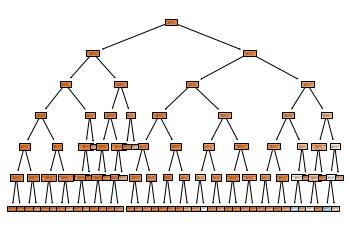

In [16]:
arbre4 = DecisionTreeClassifier(max_depth =6,min_samples_leaf= 10)
arbre4.fit(data_train_dencode_3,y_train)
tree.plot_tree(arbre4, filled=True,feature_names=data_train_dencode_3.columns)
plt.show()

In [17]:
mesure_perf(data_train_dencode_3,y_train, arbre4)

Matrice de confusion :
[[4371   10]
 [ 261   15]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4381
           1       0.60      0.05      0.10       276

    accuracy                           0.94      4657
   macro avg       0.77      0.53      0.53      4657
weighted avg       0.92      0.94      0.92      4657

aire sous la courbe ROC : 0.5260326211009995
aire sous la courbe PRC : 0.08865335959892073


In [18]:
mesure_perf(data_test_dencode_3,y_test, arbre4)

Matrice de confusion :
[[1088    5]
 [  71    1]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1093
           1       0.17      0.01      0.03        72

    accuracy                           0.93      1165
   macro avg       0.55      0.50      0.50      1165
weighted avg       0.89      0.93      0.91      1165

aire sous la courbe ROC : 0.5046571617363017
aire sous la courbe PRC : 0.0632590208233985


Conclusion intermédiaire : des arbres 1,2,3,4 donne 'accuracy' assez élévés mais des résultats sur classe 1 sont faibles.

## Over sampling

In [19]:
#avec imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

#over sampling naif
ros = RandomOverSampler(random_state=0)#initialisation de la méthode avc spécification ou non de la graine
Xover, yover = ros.fit_resample(data_train_dencode_3,y_train)

In [20]:
def oversampling(donnees,nom_var):
    data=donnees.copy()
    indexval1=data.index[data[nom_var]==1]
    indexval0=data.index[data[nom_var]==0]
    #tirage aléatoire avec remise des valeurs du groupe 1
    newliste=np.random.choice(indexval1,indexval0.shape[0],replace=True).astype('int32')
    newliste1=[]
    for val in newliste:
        newliste1.append(np.min(np.where(data.index==val)))
    data_over=data.take(newliste1)
    data_over=pd.concat([data_over,data.loc[indexval0]],axis=0)
    return(data_over)

In [21]:
newdata_train = oversampling(data_train,'assur_caravane')
newdata_test = oversampling(data_test,'assur_caravane')

In [22]:
newdata_clean_train = discretisation(newdata_train)
newy_train = newdata_clean_train['assur_caravane']
# Car il existe des donndées de type chaine de charactère. 
# Donc on va transforme en type numérique avec l'aide de la méthode dummies
# créer des dummies variables
newdata_clean_train = newdata_clean_train.drop(['assur_caravane','locataire', 'assur_sante_public'],axis=1)
newdata_clean_train= newdata_clean_train.astype(str)
newdata_train_dencode_3 = pd.get_dummies(newdata_clean_train,drop_first=True)

newdata_clean_test = discretisation(newdata_test)
newy_test = newdata_clean_test['assur_caravane']
## idem pour données tests
# créer des dummies variables
newdata_clean_test = newdata_clean_test.drop(['assur_caravane','locataire', 'assur_sante_public'],axis=1)
newdata_clean_test = newdata_clean_test.astype(str)
newdata_test_dencode_3= pd.get_dummies(newdata_clean_test,drop_first=True)

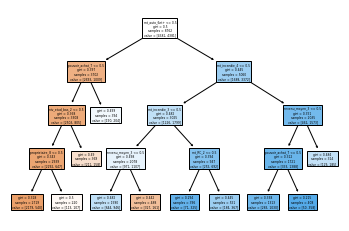

In [23]:
arbre5 = DecisionTreeClassifier(max_depth =4,min_samples_leaf= 200)
arbre5.fit(newdata_train_dencode_3,newy_train)
tree.plot_tree(arbre5, filled=True,feature_names=newdata_train_dencode_3.columns)
plt.show()

In [24]:
mesure_perf(newdata_train_dencode_3,newy_train, arbre5)
mesure_perf(newdata_test_dencode_3,newy_test, arbre5)

Matrice de confusion :
[[2830 1551]
 [ 966 3415]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.75      0.65      0.69      4381
           1       0.69      0.78      0.73      4381

    accuracy                           0.71      8762
   macro avg       0.72      0.71      0.71      8762
weighted avg       0.72      0.71      0.71      8762

aire sous la courbe ROC : 0.7127368180780643
aire sous la courbe PRC : 0.6462940462618989
Matrice de confusion :
[[719 374]
 [299 794]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1093
           1       0.68      0.73      0.70      1093

    accuracy                           0.69      2186
   macro avg       0.69      0.69      0.69      2186
weighted avg       0.69      0.69      0.69      2186

aire sous la courbe ROC : 0.6921317474839891
aire sous la courbe PRC : 0.6306101091629173


<b>Conclusion :</b> Même s'il y a une baisse d'accuracy mais le résultat sur donnée validation approche bien le résultat sur donnée d'apprentissage.
<br> - On remarque le rappel[0] il y a un sousis car le résultat sur donnée validation mieux que celui sur donnée d'apprentissage.
<br> - La partie bleue fait une grande part dans l'arbre (négatif)

## Under sampling

In [25]:
#under sampling naif
rus = RandomUnderSampler(random_state=0, replacement=True)#initialisation et choix pour replacement qui permet de spécifier
#si on veut faire un tirage avec (True) ou sans remise (False)
Xunder, yunder = rus.fit_resample(data_train_dencode_3, y_train)

In [26]:
def undersampling(donnees,nom_var):
    data=donnees.copy()
    indexval1=data.index[data[nom_var]==1]
    indexval0=data.index[data[nom_var]==0]
    #tirage aléatoire sans remise des valeurs du groupe 0
    newliste=np.random.choice(indexval0,indexval1.shape[0],replace=False).astype('int32')
    newliste1=[]
    for val in newliste:
        newliste1.append(np.min(np.where(data.index==val)))
    data_under=data.take(newliste1)
    data_under=pd.concat([data_under,data.loc[indexval1]],axis=0)
    return(data_under)

In [27]:
newdata_train2 = undersampling(data_train,'assur_caravane')
newdata_test2 = undersampling(data_test,'assur_caravane')

In [28]:
newdata_clean_train2 = discretisation(newdata_train2)
newy_train2 = newdata_clean_train2['assur_caravane']
# Car il existe des donndées de type chaine de charactère. 
# Donc on va transforme en type numérique avec l'aide de la méthode dummies
# créer des dummies variables
newdata_clean_train2 = newdata_clean_train2.drop(['assur_caravane','locataire', 'assur_sante_public'],axis=1)
newdata_clean_train2 = newdata_clean_train2.astype(str)
newdata_train_dencode2_3 = pd.get_dummies(newdata_clean_train2,drop_first=True)

newdata_clean_test2 = discretisation(newdata_test2)
newy_test2 = newdata_clean_test2['assur_caravane']
## idem pour données tests
# créer des dummies variables
newdata_clean_test2 = newdata_clean_test2.drop(['assur_caravane','locataire', 'assur_sante_public'],axis=1)
newdata_clean_test2 = newdata_clean_test2.astype(str)
newdata_test_dencode2_3= pd.get_dummies(newdata_clean_test2,drop_first=True)

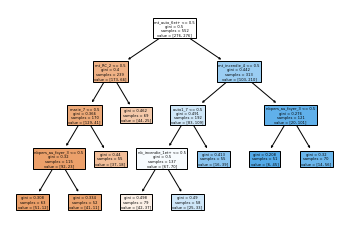

In [29]:
arbre6 = DecisionTreeClassifier(max_depth =5,min_samples_leaf= 50)
arbre6.fit(newdata_train_dencode2_3,newy_train2)
tree.plot_tree(arbre6, filled=True,feature_names=newdata_train_dencode2_3.columns)
plt.show()

In [30]:
mesure_perf(newdata_train_dencode2_3,newy_train2, arbre6)
mesure_perf(newdata_test_dencode2_3,newy_test2, arbre6)

Matrice de confusion :
[[215  61]
 [103 173]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.68      0.78      0.72       276
           1       0.74      0.63      0.68       276

    accuracy                           0.70       552
   macro avg       0.71      0.70      0.70       552
weighted avg       0.71      0.70      0.70       552

aire sous la courbe ROC : 0.7028985507246376
aire sous la courbe PRC : 0.6500061934844543


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- mt_RC_3


<b>Conclusion :</b> Résultat est moin bien que l'oversampling. (Meme s'il y a des erreurs). On ne prend pas cette modèles.

# Effectuer sur liste 1 et 2

## Liste 1

On va utiliser modele (arbre 5 pour analyser liste 1 et 2)
<br><b>Rappel</b>
<br> - Liste 1: mt_auto,mt_incendie,type_client,pouvoir_achat,revenu_moyen,mt_RC 
<br> - Liste 2:= Liste 1 + niv_etud_bas,proprietaire,revenu1,niv_etude_haut,auto0,auto1,revenu3 
<br> - Liste 3:= Liste 1 + Liste 2 + les restes (on a justement fait en haut)

In [31]:
newdata_train = oversampling(data_train,'assur_caravane')
newdata_test = oversampling(data_test,'assur_caravane')

In [32]:
liste1_train = discretisation(newdata_train)
newy_train3 = liste1_train['assur_caravane']
# Car il existe des donndées de type chaine de charactère. 
# Donc on va transforme en type numérique avec l'aide de la méthode dummies
# créer des dummies variables
liste1_train = liste1_train[['mt_auto','mt_incendie','type_client',
                                             'pouvoir_achat','revenu_moyen','mt_RC' ]]
liste1_train = liste1_train.astype(str)
newdata_train_dencode3_3 = pd.get_dummies(liste1_train,drop_first=True)

liste1_test = discretisation(newdata_test)
newy_test3 = liste1_test['assur_caravane']
## idem pour données tests
# créer des dummies variables
liste1_test = liste1_test[['mt_auto','mt_incendie','type_client',
                                             'pouvoir_achat','revenu_moyen','mt_RC' ]]
liste1_test = liste1_test.astype(str)
newdata_test_dencode3_3= pd.get_dummies(liste1_test,drop_first=True)

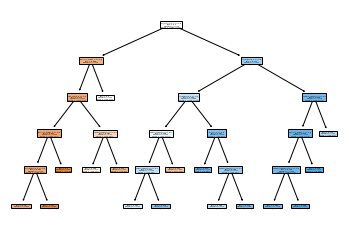

In [33]:
arbre7 = DecisionTreeClassifier(max_depth =5,min_samples_leaf= 200)
arbre7.fit(newdata_train_dencode3_3,newy_train3)
tree.plot_tree(arbre7, filled=True,feature_names=newdata_train_dencode3_3.columns)
plt.show()

In [34]:
mesure_perf(newdata_train_dencode3_3,newy_train3, arbre7)
mesure_perf(newdata_test_dencode3_3,newy_test3, arbre7)

Matrice de confusion :
[[2830 1551]
 [ 994 3387]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      4381
           1       0.69      0.77      0.73      4381

    accuracy                           0.71      8762
   macro avg       0.71      0.71      0.71      8762
weighted avg       0.71      0.71      0.71      8762

aire sous la courbe ROC : 0.7095412006391233
aire sous la courbe PRC : 0.6437254043265919
Matrice de confusion :
[[719 374]
 [320 773]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.69      0.66      0.67      1093
           1       0.67      0.71      0.69      1093

    accuracy                           0.68      2186
   macro avg       0.68      0.68      0.68      2186
weighted avg       0.68      0.68      0.68      2186

aire sous la courbe ROC : 0.6825251601097896
aire sous la courbe PRC : 0.6230095455665801


# Liste 2

In [35]:
liste2_train = discretisation(newdata_train)
newy_train4 = liste2_train['assur_caravane']
# Car il existe des donndées de type chaine de charactère. 
# Donc on va transforme en type numérique avec l'aide de la méthode dummies
# créer des dummies variables
liste2_train = liste2_train[['mt_auto','mt_incendie','type_client','pouvoir_achat','revenu_moyen','mt_RC',
                            'niv_etud_bas','locataire','proprietaire','revenu1','niv_etude_haut','auto0',
                             'auto1','revenu3' ]]
liste2_train = liste2_train.astype(str)
newdata_train_dencode4_3 = pd.get_dummies(liste2_train,drop_first=True)

liste2_test = discretisation(newdata_test)
newy_test4 = liste2_test['assur_caravane']
## idem pour données tests
# créer des dummies variables
liste2_test = liste2_test[['mt_auto','mt_incendie','type_client','pouvoir_achat','revenu_moyen','mt_RC',
                            'niv_etud_bas','locataire','proprietaire','revenu1','niv_etude_haut','auto0',
                             'auto1','revenu3' ]]
liste2_test = liste2_test.astype(str)
newdata_test_dencode4_3= pd.get_dummies(liste2_test,drop_first=True)

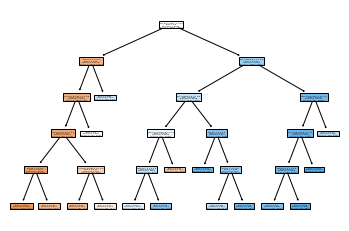

In [36]:
arbre8 = DecisionTreeClassifier(max_depth =5,min_samples_leaf= 200)
arbre8.fit(newdata_train_dencode4_3,newy_train4)
tree.plot_tree(arbre8, filled=True,feature_names=newdata_train_dencode4_3.columns)
plt.show()

In [37]:
mesure_perf(newdata_train_dencode4_3,newy_train4, arbre8)
mesure_perf(newdata_test_dencode4_3,newy_test4, arbre8)

Matrice de confusion :
[[2915 1466]
 [1046 3335]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      4381
           1       0.69      0.76      0.73      4381

    accuracy                           0.71      8762
   macro avg       0.72      0.71      0.71      8762
weighted avg       0.72      0.71      0.71      8762

aire sous la courbe ROC : 0.7133074640493038
aire sous la courbe PRC : 0.6481733790052964
Matrice de confusion :
[[732 361]
 [348 745]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      1093
           1       0.67      0.68      0.68      1093

    accuracy                           0.68      2186
   macro avg       0.68      0.68      0.68      2186
weighted avg       0.68      0.68      0.68      2186

aire sous la courbe ROC : 0.6756633119853614
aire sous la courbe PRC : 0.6183265528291991


<b>Conclusion générale :</b>
    Parmi les 3 listes proprosées par Scoring, on trouve la liste 2 est la plus performance. Avec 0.68 niveau d'accuracy. des autres indices (précision, rappel, f1-score sur classe 0 et 1 ne change pas beaucoup sur d'apprentisage et sur validation.
    <br> Cependant, il y a trop de bleue. Mais je n'arrive pas à le résourdre.